<a href="https://colab.research.google.com/github/anish-16/VIbeMatcher/blob/main/VibeMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI
import getpass

In [18]:
# --- SAFE Configuration ---
EMBEDDING_MODEL = "text-embedding-ada-002"
GOOD_SIMILARITY_THRESHOLD = 0.7

api_key = os.environ.get("OPENAI_API_KEY")

if api_key is None:
    print("OPENAI_API_KEY not found in environment variables.")
    try:
        from google.colab import userdata
        api_key = userdata.get('OPENAI_API_KEY')
        print("Attempting to load key from Colab Secrets...")
    except ImportError:
        try:
            api_key = getpass.getpass("Please paste your OpenAI API Key securely: ")
        except Exception:
            print("ERROR: Could not get API key securely.")

if api_key:
    os.environ["OPENAI_API_KEY"] = api_key
    client = OpenAI(api_key=api_key)
    print("OpenAI Client successfully initialized.")
else:
    print("FATAL: Could not initialize OpenAI Client. Embeddings will fail.")

OpenAI Client successfully initialized.


In [19]:

product_data = [
    {"name": "Boho Midi Dress", "desc": "Flowy, earthy tones and long sleeves. Perfect for a music festival or a picnic. Vibe: boho, carefree, festival.", "vibe_tags": ["boho", "carefree"]},
    {"name": "Cozy Knit Sweater", "desc": "Oversized, thick wool knit in a muted beige. Ideal for lounging at home or a chilly cabin trip. Vibe: cozy, relaxed, winter.", "vibe_tags": ["cozy", "relaxed"]},
    {"name": "Urban Racer Jacket", "desc": "Sleek black leather jacket with silver zips. A bold, sharp look for a night out in the city. Vibe: urban, energetic, edgy.", "vibe_tags": ["urban", "energetic"]},
    {"name": "Minimalist Blazer", "desc": "Structured, charcoal gray blazer with clean lines. Professional and effortlessly chic for the office. Vibe: chic, professional, structured.", "vibe_tags": ["chic", "professional"]},
    {"name": "Neon Activewear Set", "desc": "Bright, high-energy neon pink and green leggings and top. Designed for intense workouts and standing out. Vibe: energetic, athletic, vibrant.", "vibe_tags": ["energetic", "athletic"]},
    {"name": "Vintage Denim Jumpsuit", "desc": "A classic 90s wash denim, slightly worn and comfortable. Casual and retro for everyday wear. Vibe: retro, casual, comfortable.", "vibe_tags": ["retro", "casual"]},
    {"name": "Evening Sequin Gown", "desc": "Sparkling, full-length black sequin dress. Elegant and glamorous for a formal event or gala. Vibe: glamorous, elegant, formal.", "vibe_tags": ["glamorous", "formal"]},
    {"name": "Hiking Cargo Pants", "desc": "Durable, multi-pocket canvas pants built for long treks and outdoor adventures. Vibe: rugged, utilitarian, outdoors.", "vibe_tags": ["rugged", "outdoors"]},
]

df_products = pd.DataFrame(product_data)
print(f"Product Catalog Size: {len(df_products)} items.")

Product Catalog Size: 8 items.


In [20]:

def get_embedding(text, model=EMBEDDING_MODEL):
    """Fetches the embedding vector for a given text using the OpenAI API."""
    text = text.replace("\n", " ")
    if not text or client is None:
        return None

    try:
        response = client.embeddings.create(input=[text], model=model)
        return np.array(response.data[0].embedding)
    except Exception as e:
        print(f"Error generating embedding for text: {text[:20]}... Error: {e}")
        return None

print("Generating product embeddings (This may take a moment)...")
df_products['embedding'] = df_products['desc'].apply(get_embedding)

df_products.dropna(subset=['embedding'], inplace=True)
print(f"Embeddings generated for {len(df_products)} products.")

Generating product embeddings (This may take a moment)...
Error generating embedding for text: Flowy, earthy tones ... Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error generating embedding for text: Oversized, thick woo... Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error generating embedding for text: Sleek black leather ... Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details

In [21]:

def vibe_match_top_k(query_text, df, k=3):
    """
    Generates embedding for a query and finds the top-k most similar products.
    """
    start_time = time.time()

    query_embedding = get_embedding(query_text)
    if query_embedding is None:
        print("ERROR: Failed to generate embedding for the query.")
        return [], 0.0

    product_embeddings_matrix = np.vstack(df['embedding'].to_numpy())

    similarities = cosine_similarity([query_embedding], product_embeddings_matrix)[0]

    top_k_indices = np.argsort(similarities)[::-1][:k]

    results = []
    for idx in top_k_indices:
        score = similarities[idx]
        if score > 0:
            results.append({
                "name": df.iloc[idx]['name'],
                "description": df.iloc[idx]['desc'],
                "score": score,
                "vibe_tags": df.iloc[idx]['vibe_tags']
            })

    end_time = time.time()
    latency = end_time - start_time

    if not results or (results and results[0]['score'] < 0.4):
        print("\n--- ⚠️ FALLBACK TRIGGERED ---")
        best_score = results[0]['score'] if results else 0.0
        print(f"Query: '{query_text}' had no strong matches (Best score: {best_score:.4f}).")
        print("Suggestion: Try a more descriptive search, or browse our best sellers instead.")
        return [], latency

    return results, latency

initial_query = "energetic urban chic"
print(f"\n--- Running Vibe Matcher for: '{initial_query}' ---")
top_3_match, initial_latency = vibe_match_top_k(initial_query, df_products)

print(f"\n✅ Top 3 Matches for '{initial_query}':")
for i, item in enumerate(top_3_match):
    print(f"{i+1}. **{item['name']}** (Score: {item['score']:.4f})")
    print(f"   -> {item['description'][:80]}...")
    if item['score'] >= GOOD_SIMILARITY_THRESHOLD:
        print("   -> 🌟 **GOOD MATCH**")
print(f"\nLatency: {initial_latency:.4f} seconds.")


--- Running Vibe Matcher for: 'energetic urban chic' ---
Error generating embedding for text: energetic urban chic... Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
ERROR: Failed to generate embedding for the query.

✅ Top 3 Matches for 'energetic urban chic':

Latency: 0.0000 seconds.



             STARTING EVALUATION RUNS

--- Query 1: 'cozy rainy day look' ---
Error generating embedding for text: cozy rainy day look... Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
ERROR: Failed to generate embedding for the query.
Latency: 0.0000s

--- Query 2: 'energetic urban chic' ---
Error generating embedding for text: energetic urban chic... Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
ERROR: Failed to generate embedding for the query.
Late

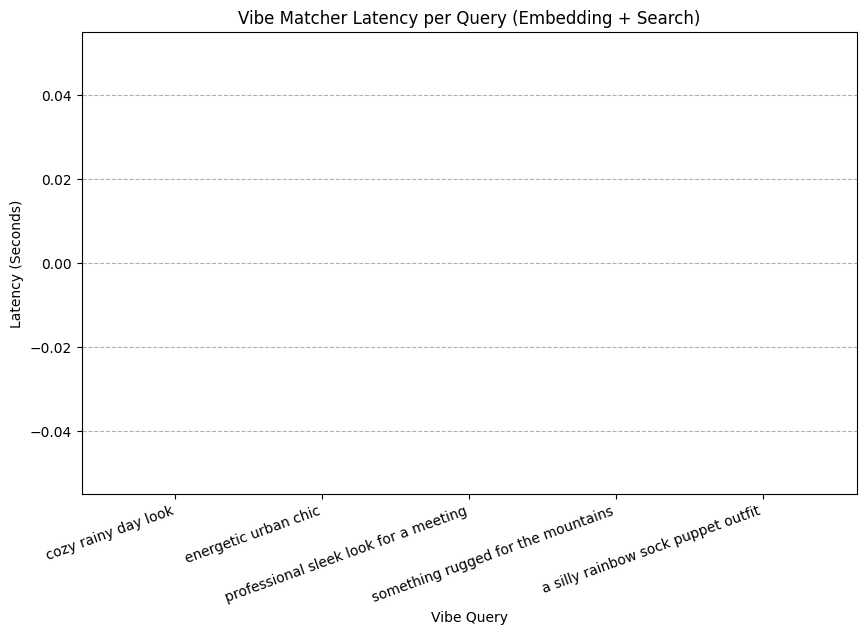


Total Queries Tested: 5
Good Matches (Score > 0.7): 0


In [22]:

test_queries = [
    "cozy rainy day look",
    "energetic urban chic",
    "professional sleek look for a meeting",
    "something rugged for the mountains",
    "a silly rainbow sock puppet outfit"
]

evaluation_log = []

print("\n" + "="*50)
print("             STARTING EVALUATION RUNS")
print("="*50 + "\n")

for i, query in enumerate(test_queries):
    print(f"--- Query {i+1}: '{query}' ---")


    results, latency = vibe_match_top_k(query, df_products)


    log_entry = {
        'Query': query,
        'Latency (s)': latency,
        'Top 1 Name': results[0]['name'] if results else 'N/A (Fallback)',
        'Top 1 Score': results[0]['score'] if results else 0.0,
        'Is Good Match (>0.7)': 'Yes' if results and results[0]['score'] >= GOOD_SIMILARITY_THRESHOLD else 'No',
        'Top 3 Results': [f"{r['name']} ({r['score']:.3f})" for r in results]
    }
    evaluation_log.append(log_entry)

    if results:
        print(f"Best Match: **{log_entry['Top 1 Name']}** (Score: {log_entry['Top 1 Score']:.4f})")
        print(f"Good Match Status: {log_entry['Is Good Match (>0.7)']}")
    print(f"Latency: {latency:.4f}s\n")

df_eval = pd.DataFrame(evaluation_log)

print("\n" + "="*50)
print("          EVALUATION SUMMARY TABLE")
print("="*50)
print(df_eval[['Query', 'Top 1 Name', 'Top 1 Score', 'Is Good Match (>0.7)', 'Latency (s)']])

plt.figure(figsize=(10, 6))
plt.bar(df_eval['Query'], df_eval['Latency (s)'], color='teal')
plt.xlabel('Vibe Query')
plt.ylabel('Latency (Seconds)')
plt.title('Vibe Matcher Latency per Query (Embedding + Search)')
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()

good_matches = df_eval[df_eval['Is Good Match (>0.7)'] == 'Yes']
print(f"\nTotal Queries Tested: {len(df_eval)}")
print(f"Good Matches (Score > {GOOD_SIMILARITY_THRESHOLD}): {len(good_matches)}")